In [ ]:
# Baseline 1: ARMA model, NVDA spot price
# Baseline 2: ARMA model, log scale, NVDA spot price

ARMA model for NVDA spot price:
Scrape using Beautiful Soup, display using Pandas

In [1]:
# Imports
# To import, run "conda install -c conda-forge <package1> <package2>" in the Anaconda prompt
import os
import lxml
import pandas as pd
from bs4 import BeautifulSoup
from scipy import stats, signal
from scipy.optimize import minimize
import yfinance as yf
import datetime as dt
from datetime import date
import matplotlib.pyplot as plt
import numpy as np
import quantstats as qs

# Magic function to enable matplotlib charting in jupyter notebooks
%matplotlib inline

In [48]:
# Tickers
nvda = yf.Ticker("NVDA") 
qqq = yf.Ticker("QQQ")

In [49]:
data = nvda.history(period="5y", interval="1wk")
qqq_data = qqq.history(period="5y", interval="1wk")

In [53]:
print(data.head())

                               Open      High  ...  Dividends  Stock Splits
Date                                           ...                         
2020-02-24 00:00:00-05:00  6.524150  6.857503  ...      0.004           0.0
2020-03-02 00:00:00-05:00  6.897723  7.096758  ...      0.000           0.0
2020-03-09 00:00:00-04:00  5.976035  6.503640  ...      0.000           0.0
2020-03-16 00:00:00-04:00  5.291243  5.737390  ...      0.000           0.0
2020-03-23 00:00:00-04:00  5.124343  6.554457  ...      0.000           0.0

[5 rows x 7 columns]


In [51]:
#export
csvx = data[['Open', 'High', 'Low', 'Close']].to_csv("nvda_weekly_spot.csv", float_format="%.3f")
csvnq = qqq_data[['Open', 'High', 'Low', 'Close']].to_csv("qqq_weekly_spot.csv", float_format="%.3f")

In [52]:
print(data.describe())

             Open        High  ...   Dividends  Stock Splits
count  262.000000  262.000000  ...  262.000000    262.000000
mean    42.125947   44.504179  ...    0.000374      0.053435
std     41.121486   43.313976  ...    0.001432      0.664514
min      5.124343    5.737390  ...    0.000000      0.000000
25%     14.171155   14.829985  ...    0.000000      0.000000
50%     22.236909   23.060505  ...    0.000000      0.000000
75%     48.096403   49.811496  ...    0.000000      0.000000
max    148.669750  153.130005  ...    0.010000     10.000000

[8 rows x 7 columns]


In [42]:
data.info()
data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 262 entries, 2020-02-24 00:00:00-05:00 to 2025-02-24 00:00:00-05:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          262 non-null    float64
 1   High          262 non-null    float64
 2   Low           262 non-null    float64
 3   Close         262 non-null    float64
 4   Volume        262 non-null    int64  
 5   Dividends     262 non-null    float64
 6   Stock Splits  262 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 16.4 KB


Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64

In [43]:
dfm = pd.read_csv("nvda_weekly_spot.csv")
print(dfm.head())

                        Date   Open   High    Low  Close
0  2020-02-24 00:00:00-05:00  6.524  6.858  6.020  6.724
1  2020-03-02 00:00:00-05:00  6.898  7.097  6.427  6.627
2  2020-03-09 00:00:00-04:00  5.976  6.504  5.376  5.999
3  2020-03-16 00:00:00-04:00  5.291  5.737  4.501  5.125
4  2020-03-23 00:00:00-04:00  5.124  6.554  4.945  6.296


In [4]:
# This class will download data from yahoo finance
class FinancialData:
    
    # Class constructor to store parameters, download and format data
    def __init__(self, ticker, startDate, endDate):
        
        # Member Data
        self.ticker = ticker
        self.startDate = startDate
        self.endDate = endDate

        # Download and Format Data
        self.download_data()
        self.prepare_data()

    # Download data from yahoo finance
    def download_data(self):
        print(f"Downloading Data from Yahoo Finance for {self.ticker}")
        self.raw_data = yf.download(self.ticker, self.startDate, self.endDate)

    # Compute returns and drop NaN values
    def prepare_data(self):
        
        # Grab columns of interest
        copy_columns = ['Close']
        self.df = self.raw_data[copy_columns].copy()
        
        # Compute returns and drop NaN values
        self.df["Returns"] = np.log(self.df['Close'] / self.df['Close'].shift(1))
        self.df.dropna(inplace=True)
    
    def plot_data(self, cols=None):
        if cols is None:
            cols = ['Close']
        self.df[cols].plot(title=self.ticker)

[*********************100%***********************]  1 of 1 completed

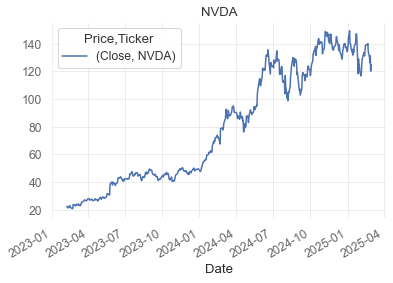

In [5]:
# Example 1: NVDA
# 1. Define Ticker
ticker = "NVDA"

# 2. Define Back Test Period
nYears = 3

# Sytax for a specific end date
# endDate = dt.datetime(2021,6,30).date()

endDate = date.today()
startDate = endDate - pd.Timedelta(days=nYears * 252)

# 3. Load Data
fd = FinancialData(ticker, startDate, endDate)

# 4. Plot Data
fd.plot_data()

[*********************100%***********************]  1 of 1 completed

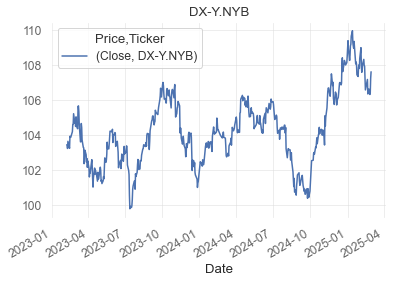

In [8]:
# Example 2: DXY
# 1. Define Ticker
ticker = "DX-Y.NYB"

# 2. Define Back Test Period
nYears = 3

# Sytax for a specific end date
# endDate = dt.datetime(2021,6,30).date()

endDate = date.today()
startDate = endDate - pd.Timedelta(days=nYears * 252)

# 3. Load Data
fd = FinancialData(ticker, startDate, endDate)

# 4. Plot Data
fd.plot_data()

In [2]:
def base_ar(price, time):
    
    X = np.zeros((len(price) - time, time + 1))
    y = price[time:].values
    
    
    X[:, 0] = 1  
    for i in range(len(price) - time):
        X[i, 1:] = price[i:i+time].values
    
    #Ordinary Least Squares fitting
    coefficients = np.linalg.lstsq(X, y, rcond=None)[0]
    fitted = np.dot(X, coefficients)
    residuals = y - fitted
    
    print(f"AR({time}) Coefficients:")
    print(f"Intercept: {coefficients[0]:.4f}")
    for i in range(1, len(coefficients)):
        print(f"Weeks: {i}: {coefficients[i]:.4f}")
    
    return coefficients, residuals

In [6]:
def base_ar_predict(prices, coefficients, residuals, k=3):
    
    residual_std = np.std(residuals)
    z = 1.96  #95% CI

    lags = len(coefficients) - 1
    recent_prices = prices[-lags:].values

    predictions = []
    lower_bounds = []
    upper_bounds = []
    
    for i in range(k):

        next_price = coefficients[0] 
        for j in range(lags):
            if i + j < lags:
                next_price += coefficients[j+1] * recent_prices[-(lags-j)]
            else:
                next_price += coefficients[j+1] * predictions[i+j-lags]
        
        prediction_error = z * residual_std
        lower_bound = next_price - prediction_error
        upper_bound = next_price + prediction_error
        
        predictions.append(next_price)
        lower_bounds.append(lower_bound)
        upper_bounds.append(upper_bound)
    
    last_date = prices.index[-1]
    pred_dates = pd.date_range(start=last_date + pd.Timedelta(days=7), 
                               periods=k, 
                               freq='W-MON')
    
    
    results = pd.DataFrame({
        'Prediction': predictions,
        'Lower_Bound': lower_bounds,
        'Upper_Bound': upper_bounds
    }, index=pred_dates)
    
    return results

In [10]:
nvda = yf.Ticker("NVDA")
data = nvda.history(period="5y", interval="1wk")
close_prices = data['Close']
c, r = base_ar(close_prices, 15)
price_pred = base_ar_predict(close_prices, c, r, 3)
print("\nAutoregressive NVDA Price Prediction:")
print(price_pred)

AR(15) Coefficients:
Intercept: 0.4432
Weeks: 1: -0.0628
Weeks: 2: 0.0346
Weeks: 3: -0.0077
Weeks: 4: -0.0127
Weeks: 5: 0.0379
Weeks: 6: 0.0419
Weeks: 7: 0.1775
Weeks: 8: -0.1849
Weeks: 9: -0.1433
Weeks: 10: 0.1777
Weeks: 11: -0.2071
Weeks: 12: 0.1740
Weeks: 13: 0.0505
Weeks: 14: -0.0193
Weeks: 15: 0.9437

Autoregressive NVDA Price Prediction:
                           Prediction  Lower_Bound  Upper_Bound
2025-03-10 01:00:00-04:00  117.099066   109.351257   124.846875
2025-03-17 01:00:00-04:00  116.909432   109.161624   124.657241
2025-03-24 01:00:00-04:00  116.881339   109.133530   124.629148
